In [3]:
import numpy as np
import seaborn as sns
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/')
from trained_untrained_results_funcs import find_best_layer, loop_through_datasets

In [4]:
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica'

## Generate simple features for fedorenko

In [5]:
# include punctuation
from scipy.ndimage import gaussian_filter1d

word_len = []
with open('/data/LLMs/data_processed/fedorenko/text/sentences_ordered.txt', 'r') as file:
    for line in file:
        words = line.split()
        word_len.extend([len(word) for word in words])
    
word_len = np.expand_dims(word_len, axis=-1)
growing_act = np.expand_dims(np.tile([0, 1, 2, 3, 4, 5, 6, 7], 52),axis=-1)

# Initialize the matrix
rows, cols = 416, 8
pos_matrix = np.zeros((rows, cols))

# Fill the matrix with the cyclic one-hot encoding
for i in range(rows):
    pos_matrix[i, i % cols] = 1
    
sigma_range = np.round(np.arange(0, 4.8, 0.1),2)
position_fed = {}
wn_position_fed = {}
for s in sigma_range:
    if s == 0:
        print(s)
        position_fed[f'layer_{s}'] = np.hstack((pos_matrix, growing_act))
        wn_position_fed[f'layer_{s}'] = np.hstack((pos_matrix, growing_act, word_len)) 
    else:
        position_fed[f'layer_{s}'] =  np.hstack((np.array([gaussian_filter1d(row, sigma=s) for row in pos_matrix]),growing_act))
        wn_position_fed[f'layer_{s}'] = np.hstack((np.array([gaussian_filter1d(row, sigma=s) for row in pos_matrix]),growing_act, word_len))


np.savez('/data/LLMs/data_processed/fedorenko/acts/X_pos.npz', **position_fed)
np.savez('/data/LLMs/data_processed/fedorenko/acts/X_wn+pos.npz', **wn_position_fed)
#fed_position = np.load('/data/LLMs/data_processed/fedorenko/acts/X_soft+grow.npz')['layer1']
#fed_position_word_len = np.hstack((fed_position, np.expand_dims(word_len,axis=-1)))
#np.savez('/data/LLMs/data_processed/fedorenko/acts/X_soft+grow.npz')

0.0


In [8]:
sigma_range = np.round(np.arange(0, 4.8, 0.1),2)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7])

In [105]:
for dataset, fe, exp, subjects, network in loop_through_datasets(['fedorenko'], ['']):

    layer_perf_dict, best_layer, layer_perf_best  = find_best_layer([1], noL2_str='', 
                    exp=exp, resultsPath='/data/LLMs/brainscore/results_fedorenko/', subjects=subjects, 
                    dataset='fedorenko', perf='out_of_sample_r2', 
                    selected_network_indices = np.arange(network.shape[0]), 
                    feature_extraction = '', model_name=f'glove_wn+pos', 
                    seed_number=None, 
                    return_SE=False, niter=1000)
    print(best_layer)
    print(layer_perf_dict[best_layer])

1
0.04867559145721991


In [101]:
glove_sp = np.load('/data/LLMs/data_processed/fedorenko/acts/X_glove-sp.npz')['layer_0']
np.savez('/data/LLMs/data_processed/fedorenko/acts/X_glove_wn+pos', **{'layer1':np.hstack((glove_sp, wn_position_fed['layer_4.3']))})

## Generate simple features for blank

In [2]:
def get_pos_for_story(len_story, len_pos=30):
    return np.clip((np.arange(0,len_pos) * np.ones((len_story,len_pos))).T,
                    np.zeros(len_story), np.clip(np.arange(0,len_story),0,len_pos) ).T
    
def get_pos_for_stories(story_lens, len_pos=30):
    return np.concatenate([get_pos_for_story(l, len_pos) for l in story_lens])


dataset='blank'
blank_data = np.load(f"{basePath_data}{dataset}/text/story_data_dict.npz")
experiment_txt = []
data_labels = []
for key, val in blank_data.items():
    experiment_txt.extend(val)
    data_labels.extend(np.repeat(key, len(val)))

story_lens = np.diff(np.append(np.unique(data_labels, return_index=True)[1],1317))
blank_simple_acts = {}
for i in np.arange(3,51):
    blank_acts = get_pos_for_stories(story_lens,i) # get the ramping activations used by Antonello 
    blank_acts = blank_acts[:, 1:] # remove the 0th dimension since it's a constant anyways
    blank_acts = np.concatenate((np.array(([len(x.split()) for x in experiment_txt] * 1)).reshape(1,1317).T, blank_acts),axis=1) # stack on a word rate feature
    blank_simple_acts[f'layer_{i}'] = blank_acts

In [36]:
np.savez('/data/LLMs/data_processed/blank/acts/X_pos-WN', **blank_simple_acts)

<Axes: >

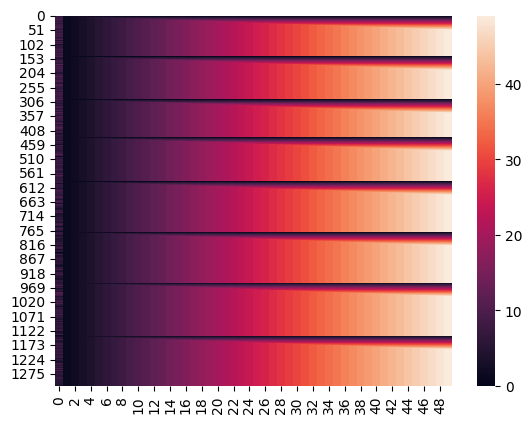

In [34]:
sns.heatmap(blank_acts)